<a href="https://colab.research.google.com/github/soyoonjeong/deeplearning_from_scratch/blob/main/ch7_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가
- 합성곱 계층과 풀링 계층은 im2col(이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율저긍로 구현할 수 있음
- CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있음
- 대표적인 CNN에는 LeNet, AlexNet이 있음
- 딥러닝의 발전에는 빅데이터와 GPU가 크게 기여함 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
%cd /content/drive/MyDrive

/content/drive/MyDrive


# 전체 구조

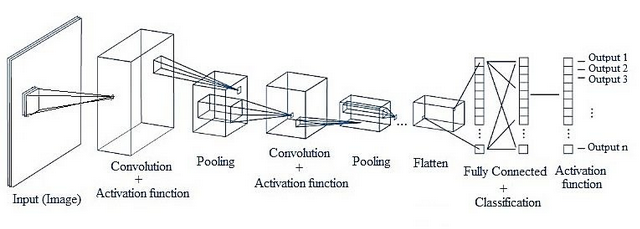

- **Convolution -> ReLU(Activation function) -> (Pooling)** 흐름으로 연결
- 출력에 가까운 층에서는 지금까지의 'Affine-ReLU' 구성을 사용, 마지막 출력 계층에서는 'Affine-Softmax' 조합 사용 

# 합성곱 계층 

## 완전연결 계층의 문제점 

PROBLEM : 완전연결 계층 <br>
- 형상을 무시하고 모든 입력 데이터를 동등한 뉴런으로 취급하여 형상에 담긴 정보를 살릴 수 없음
- 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화해줘야 함 
- ex) 공간적으로 가까운 픽셀은 값이 비슷, RGB 각 채널은 서로 밀접하게 관련되어 있음, 거리가 먼 픽셀끼리는 별 연관 없음 등의 패턴 무시 

SOLUTION : 합성곱 계층<BR>
- 형상 유지, 3차원 데이터로 입력받고 3차원 데이터로 출력함 

## 합성곱 연산

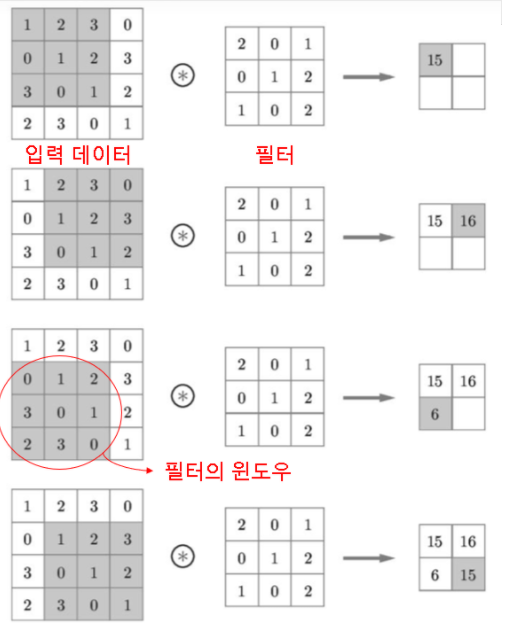

- 필터의 윈도우를 일정 간격으로 이동해가며 입력 데이터에 적용
- 입력과 필터에 대응하는 원소끼리 곱한 후 그 총합 구함 (**단일 곱셈-누산**) -> 출력의 해당 장소에 저장
- 가중치 : 필터의 매개변수, 편향 : 하나만 존재, 필터 적용한 후 데이터에 더해짐짐

## 패딩 (padding) 

PROBLEM : 합성곱 연산을 거칠 때마다 크기가 작아지면서 어느 시점에서 더 이상은 합성곱 연산을 적용할 수 없게 됨 <BR>

SOLUTION : **패딩** <BR>
- 입력 데이터 주변을 특정 값(0)으로 채움
- 패딩을 크게 하면 출력 크기 커짐 
- 출력 크기를 조정할 목적으로 사용함 
- 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있음

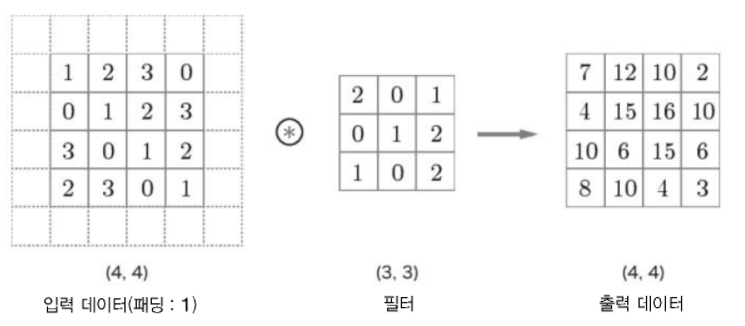

## 스트라이드 (stride)

- 필터를 적용하는 위치의 간격 (필터의 발걸음 크기)
- 스트라이드를 키우면 출력의 크기는 작아짐 

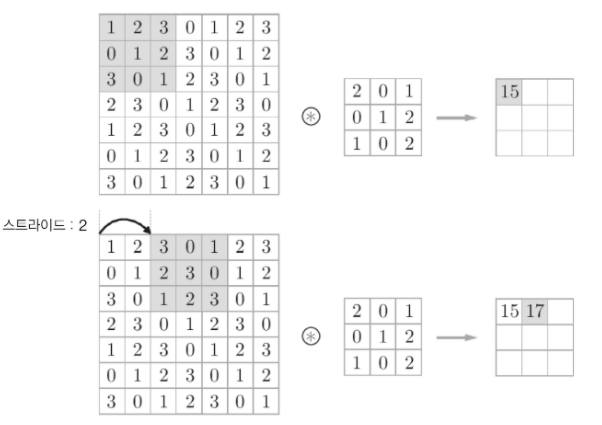

### 입력 크기, 필터 크기, 패딩, 스트라이드로 출력 크기 계산 

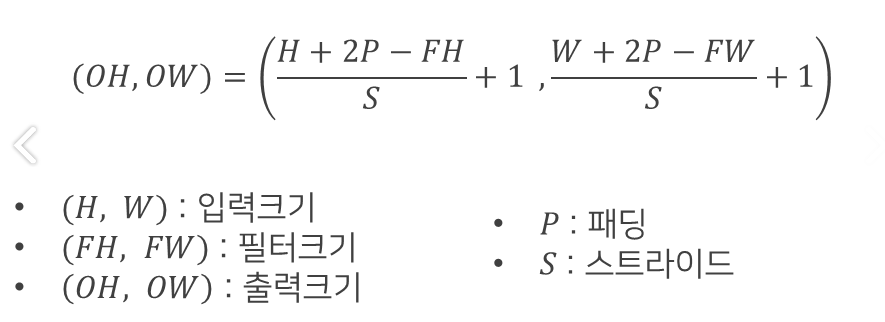

## 필터 1개 : 3차원 데이터의 합성곱 연산 

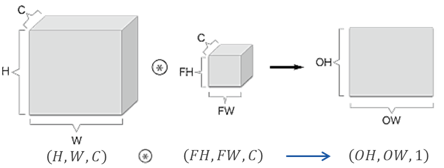

- 채널 쪽으로 특징 맵이 여러 개 있다면 입력 데이터 필터의 합성곱 연산을 채널마다 수행하고, 그 결과를 더해서 하나의 출력을 얻음 
- 입력 데이터의 채널 수 = 필터의 채널 수 

## 필터 여러 개 : 블록으로 생각하기 

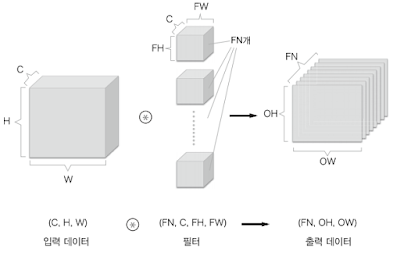

- 필터를 FN개 적용하면 출력 맵도 FN개 생성 
- 필터의 가중치 데이터는 4차원 데이터 (출력 채널 수, 입력 채널 수, 높이, 너비)

## 배치 처리 

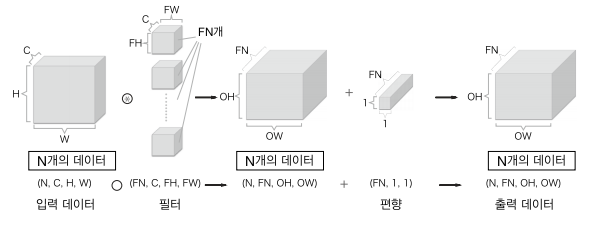

배치 처리 : 입력 데이터를 한 덩이로 묶어 배치로 처리 => 데이터를 (데이터 수, 채널 수, 높이, 너비) 4차원 데이터로 저장 <BR>
- 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산 수행행

# 풀링 계층 

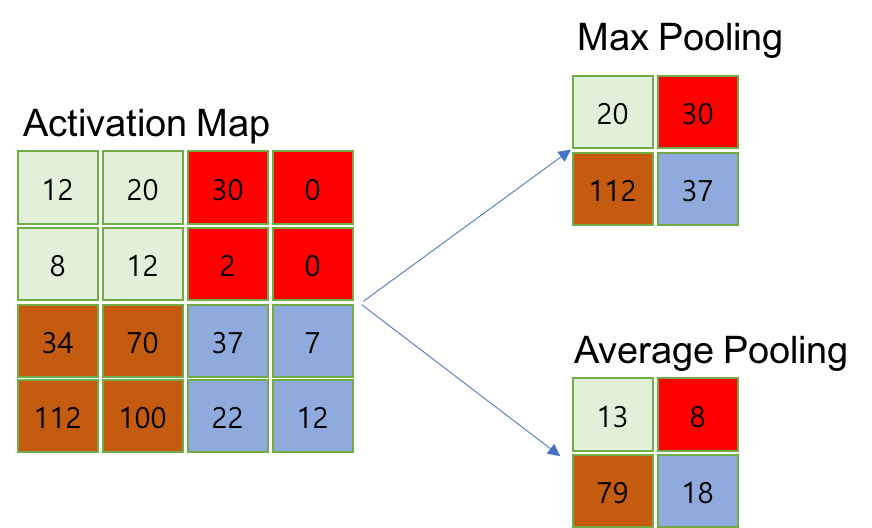

**풀링** : 세로, 가로 방향의 공간을 줄이는 연산 <BR>
- n x n 최대 풀링 : nxn 크기의 영역에서 최댓값 구하는 연산
- n x n 평균 풀링 : nxn 크기의 영역에서 평균값 구하는 연산
- 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정

- 학습해야 할 매개변수가 없음 => 명확한 연산
- 채널 수가 변하지 않음 => 채널마다 독립적으로 계산
- 입력의 변화에 영향을 적게 받음 (강건함) 

# 합성곱/풀링 계층 구현하기

## 4차원 배열 

In [ ]:
# CNN에서 계층 사이를 흐르는 데이터는 4차원
x = np.random.rand(10, 1, 28, 28)
print(x.shape)
print(x[0].shape)

(10, 1, 28, 28)
(1, 28, 28)


## im2col로 데이터 전개하기 

**im2col** : image to column (이미지에서 행렬로) <br>
- 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는 함수
- 입력 데이터에서 필터를 적용하는 영역(3차원 블록)을 한 줄로 늘어놓음 
- 메모리를 더 많이 소비 => 원소 수가 원래 블록의 원소 수보다 많아짐
- 선형 대수 라이브러리를 활용해 효율을 높일 수 있음 

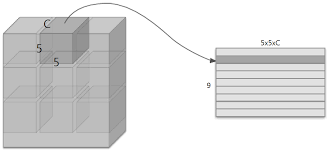

## 합성곱 계층 구현하기 

In [ ]:
from common.util import im2col

x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape) # 채널 3개, 5x5 데이터 => 75, (7+0-5)/1+1 = 3, 3x3 => 9

(9, 75)
(90, 75)


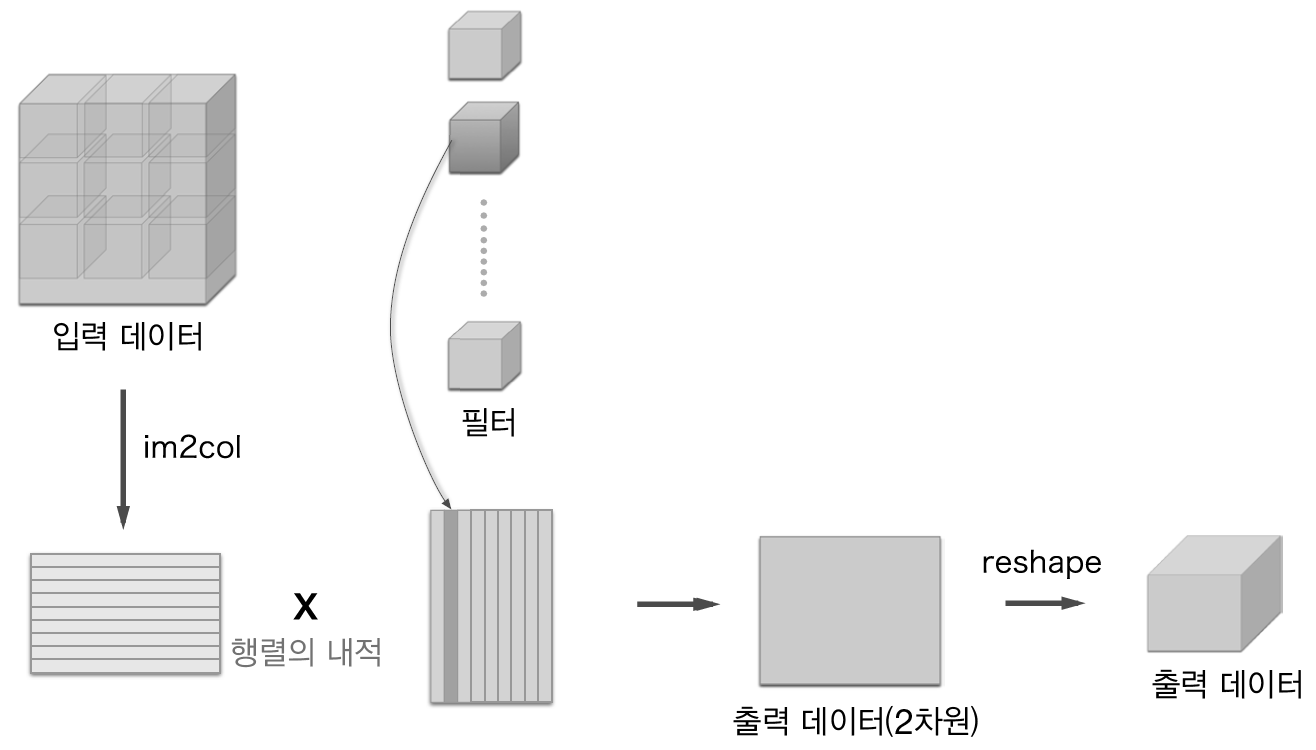

In [ ]:
class Convolution:
  def __init__(self, w, b, stride = 1, pad = 0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int((H+2*self.pad-FH)/self.stride + 1)
    out_w = int((W+2*self.pad-FW)/self.stride + 1)

    col = im2col(x, FH, FW, self.stride, self.pad) # image -> column
    col_W = self.W.reshape(FN, -1).T # 필터 전개
    out = np.dot(col, col.W) + self.b # 합성곱 연산

    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # 적절한 형상으로 바꾼 후 축 순서 변경 

    return out

## 풀링 계층 구현하기 

In [4]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int((H-self.pool_h)/self.stride + 1)
    out_w = int((W-self.pool_w)/self.stride + 1)

    # 입력 데이터 전개
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    # 행별 최댓값
    out = np.max(col, axis = 1)

    # 적절한 모양으로 성형
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    return out

# CNN 구현하기

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train loss:0.0007249598750205691
train loss:0.0007432956645031636
train loss:0.011277824739898346
train loss:0.0025293638528334867
train loss:0.0016860793973694605
train loss:0.0033941653454456124
train loss:0.00926055673138665
train loss:0.002368992176631994
train loss:0.0008050435715502846
train loss:0.0050826276456379885
train loss:0.003058201260216884
train loss:0.00443694331112303
train loss:0.00860639546997592
train loss:0.0007220156199116887
train loss:0.001603281619842775
train loss:0.0013046612741994933
train loss:0.0019650939718595917
train loss:0.0006746188320583374
train loss:0.0035364978318625406
train loss:0.0007399165082748954
train loss:0.002254059618154931
train loss:0.0036395519496616006
train loss:0.0008574091425324651
train loss:0.001056187441608735
train loss:0.0013531552986767554
train loss:0.02843097233936386
train loss:0.007093960740208666
train loss:0.0027729131828096803
train loss:0.00546610677924038
train loss:0.00504364599

KeyboardInterrupt: ignored

# CNN 시각화하기

## 1번째 층의 가중치 시각화하기 

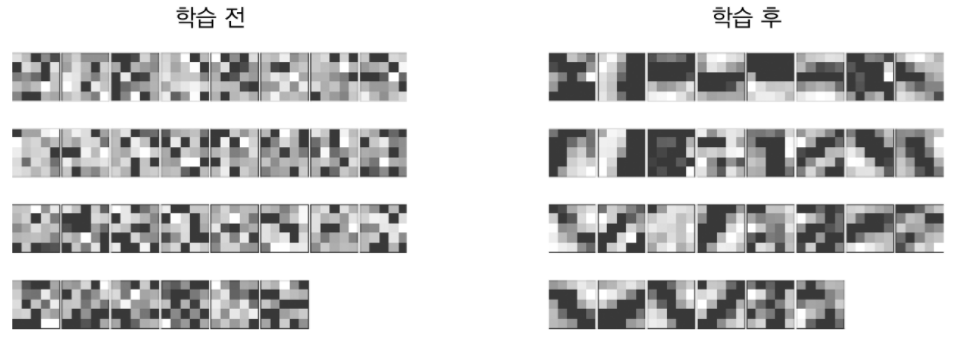

- 학습 전 : 필터가 무작위로 초기화 => 흑백의 정도에 규칙성이 없음
- 학습 후 : 필터가 규칙성있는 이미지가 됨 => 흰색에서 검은색으로 점차 변화, 덩어리가 진 필터, 규칙을 띄는 필터로 변화함
- 규칙성 있는 필터는 에지(색상이 바뀐 경계선), 블롭(국소적으로 덩어리진 영역) 등을 봄

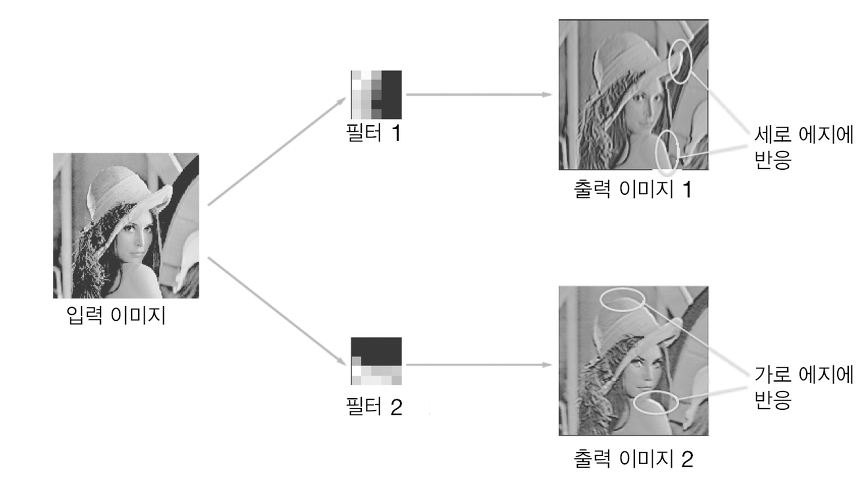

## 층 깊이에 따른 추출 정보 변화 

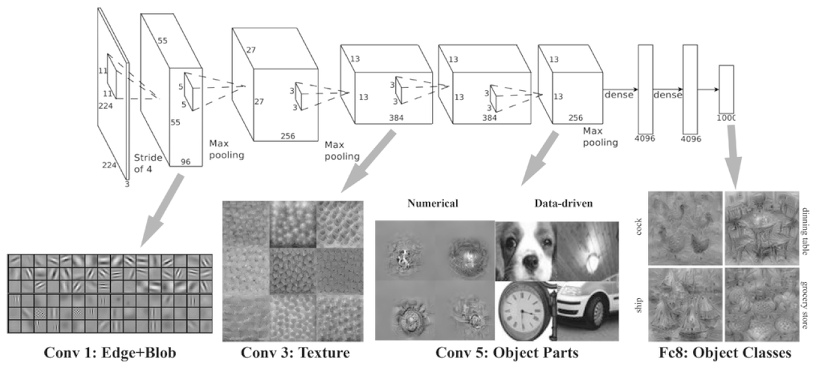

- 합성곱 계층을 여러 겹 쌓으면 층이 깊어지면서 더 복잡하고 추상회된 정보가 추출됨
- 처음 층은 단순한 에지에 반응하고 이어서 텍스처에 반응하고 더 복잡한 사물의 일부에 반응하도록 변화
- **층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 고급 정보로 변화** 

# 대표적인 CNN 

## LeNet

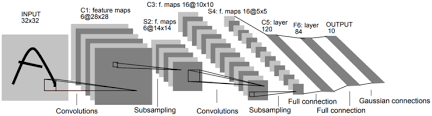

- CNN의 원조
- 합성곱 계층과 풀링계층(서브샘플링 계층)을 반복하고 마지막으로 완전연결 계층을 거치면서 결과를 출력
- 현재와 활성화함수 차이 : LeNet은 시그모이드 함수를 사용하는데 반해 현재는 주로 ReLU를 사용
- 현재와 출력 맵 크기 줄이는 방법 차이 : LeNet은 단순히 원소를 줄이는 서브샘플링 계층을 사용하는 것에 반해 현재는 최대풀링이 주류류

## AlexNet

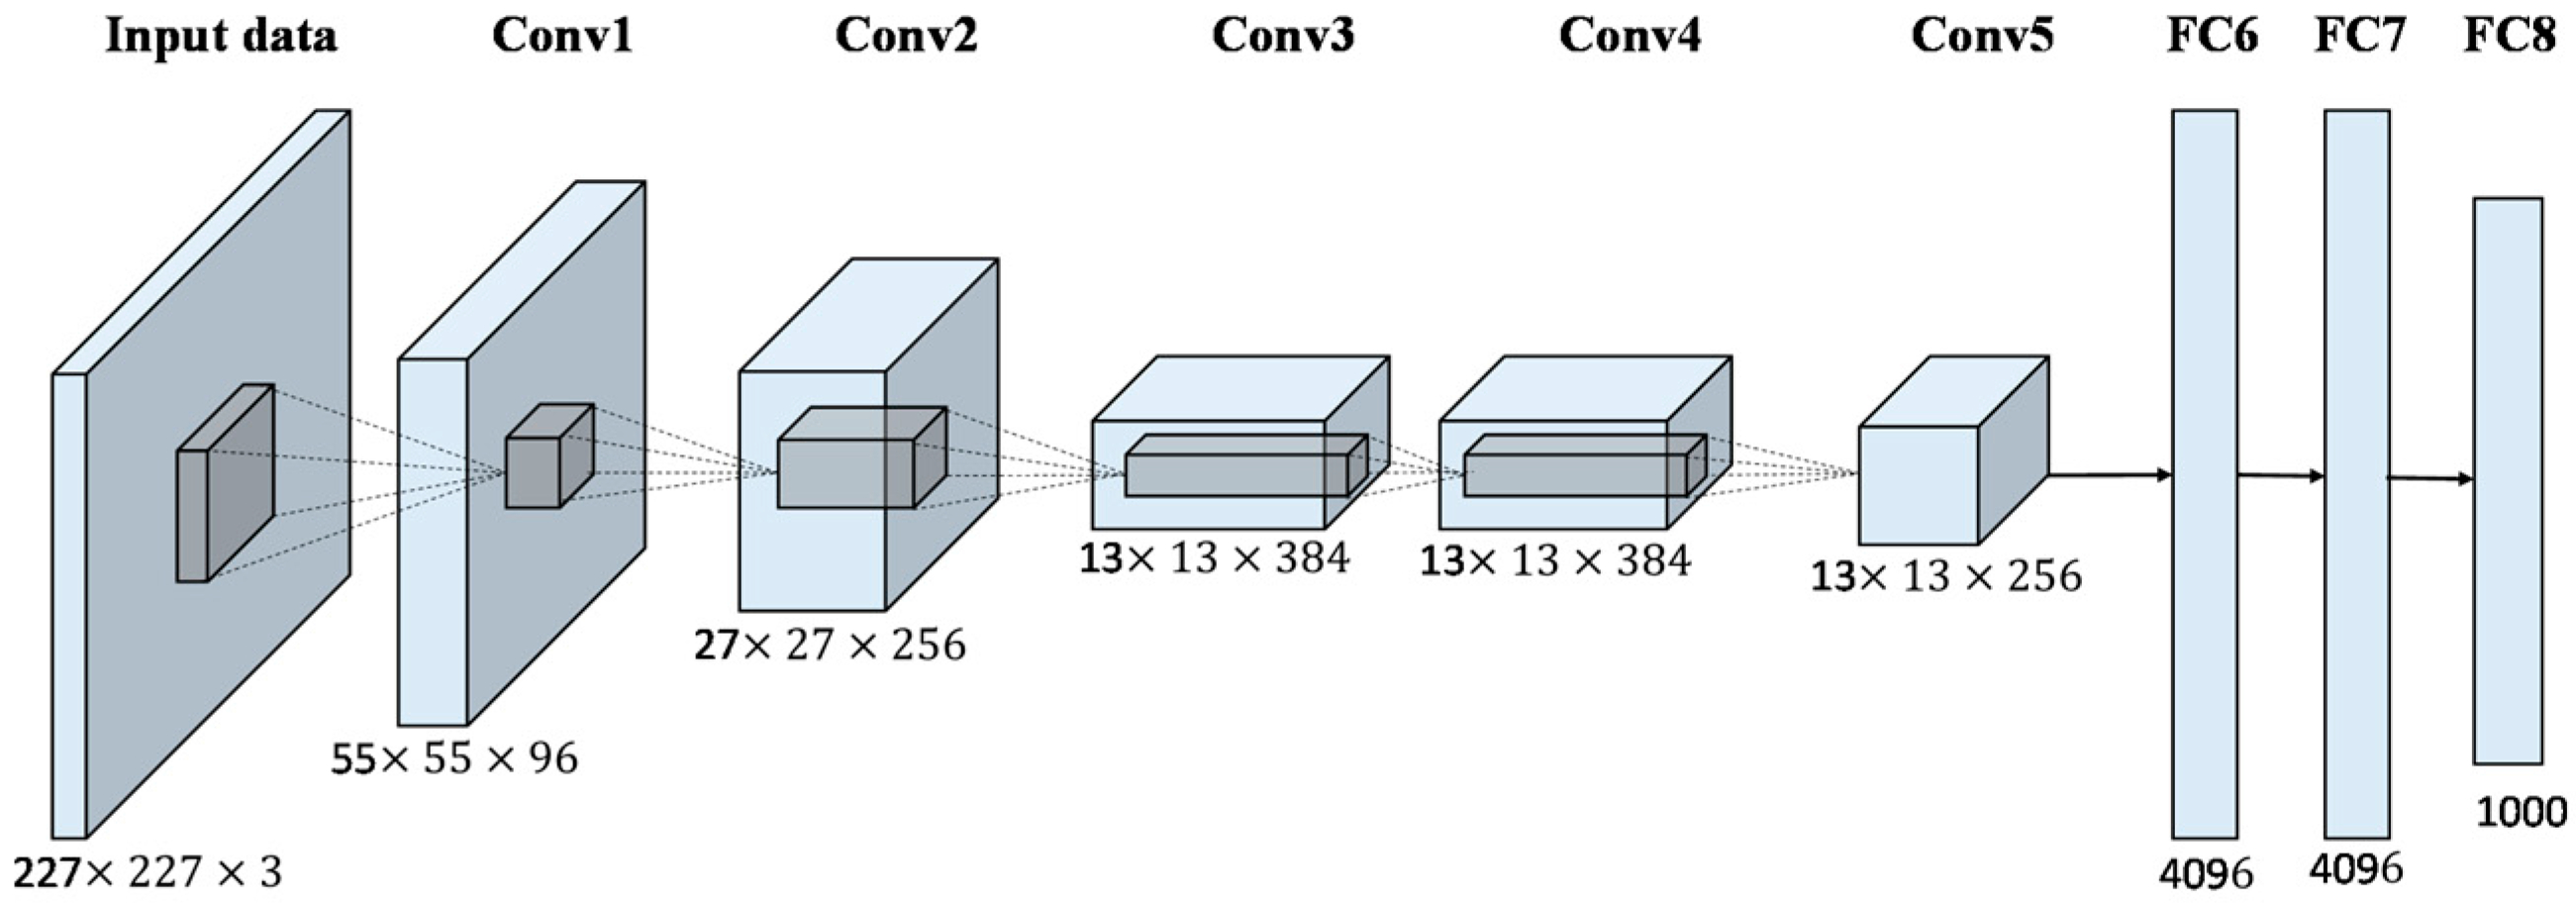

- 딥러닝이 주목받도록 이끔
- 합성곱 계층과 풀링 계층을 거듭하며 마지막으로 완전연결 계층 거쳐 결과 출력
- 활성화함수로 ReLU 사용
- LRN(Local Response Normalization)이라는 국소적 정규화를 실시하는 계층 이용
- 드롭아웃 사용 